# Aug 22

## Creating a random structure and SQS

using pymatgen package

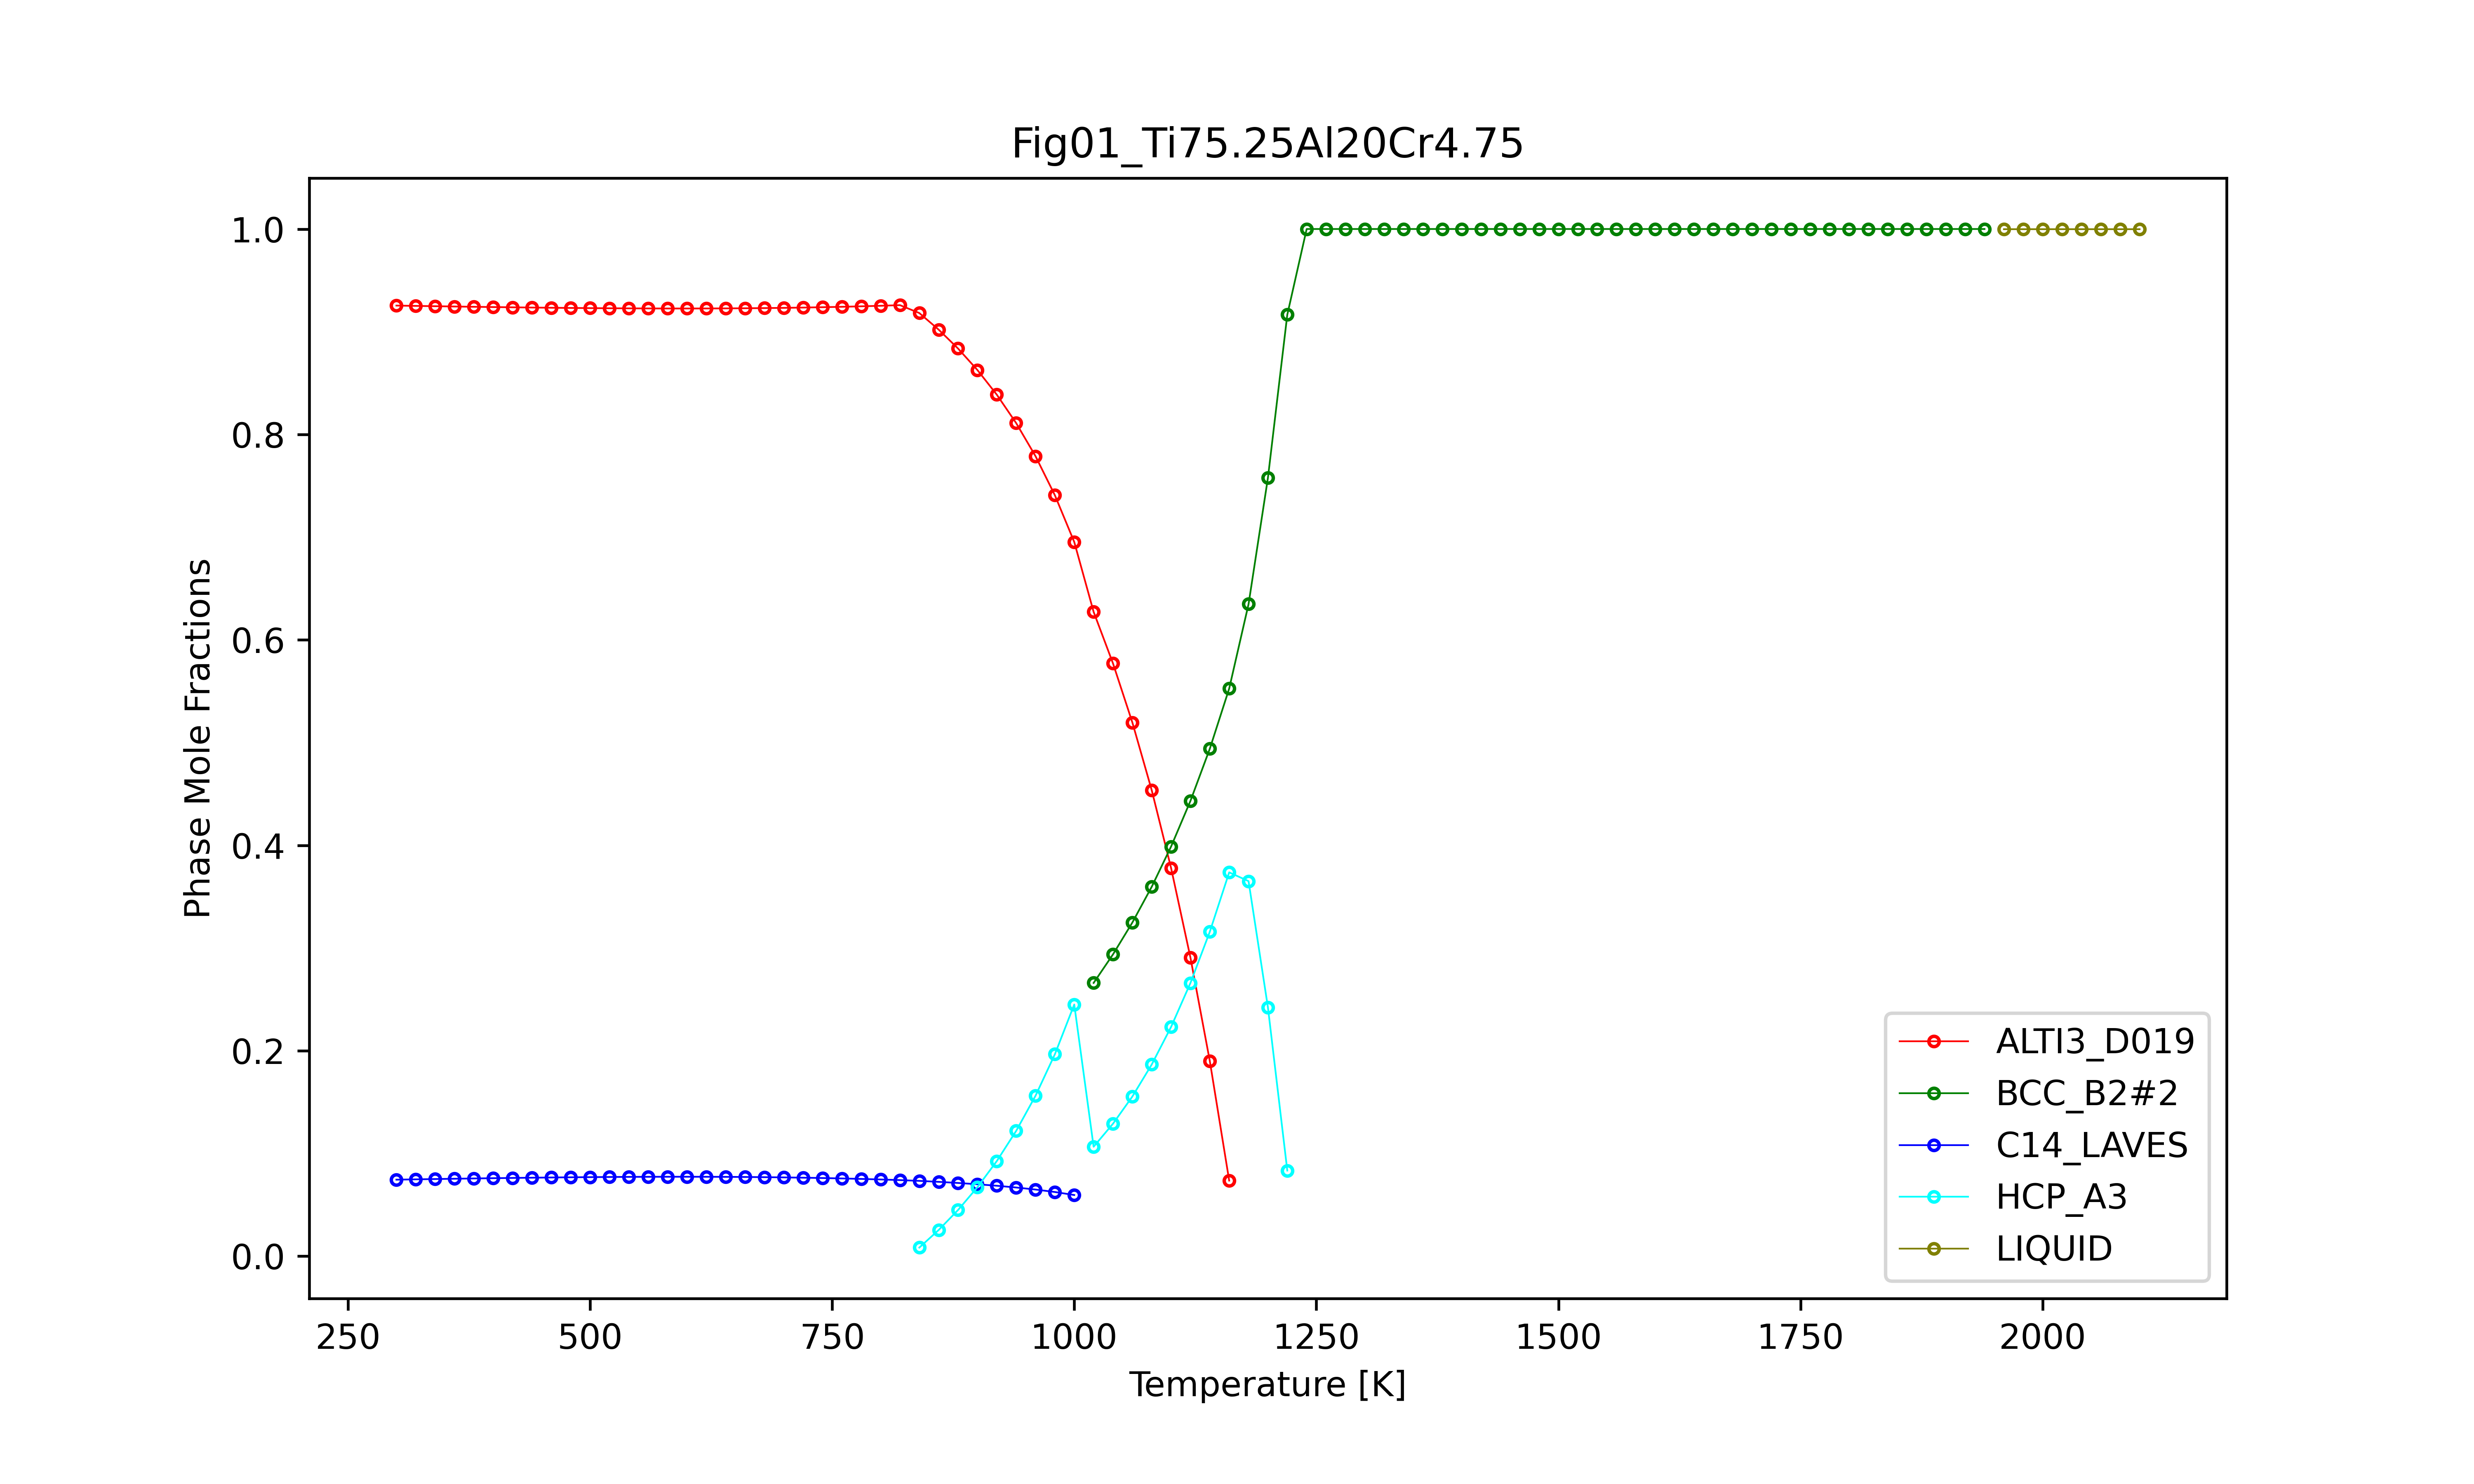

In [12]:
from mp_api.client import MPRester
from pymatgen.core import Structure, Lattice, Composition
import numpy as np

# bcc Ti, Al and Cr
mp_ids = ["mp-73", "mp-998860", "mp-90"]

MP_API_KEY = 'd3bZ5jRgDZ3uYsKhZnUK4agoNYBjj4og'

mpr =  MPRester(MP_API_KEY)

lattice_params = []
mats = mpr.materials.search(mp_ids, fields=["structure"])

for mat in mats:
    struct = mat.structure
    a = struct.lattice.a  # For cubic cells
    lattice_params.append(a)
    
print(lattice_params)
avg_params = np.mean(lattice_params)
print(f"Average lattice parameter: {avg_params}")


Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

[2.96889915140125, 2.8159986696554085, 2.756071617033191]
Average lattice parameter: 2.8469898126966164


In [13]:
from fractions import Fraction

comp = Composition("Ti75.25Al20Cr4.75")
# Get atomic fractions
fractions = {el.symbol: comp.get_atomic_fraction(el) for el in comp.elements}
# Find smallest N for integer atom counts

denoms = [Fraction(str(frac)).limit_denominator().denominator for frac in fractions.values()]
N = np.lcm.reduce(denoms)
atom_counts = {el: int(round(frac * N)) for el, frac in fractions.items()}

print(f"Smallest cell size for exact composition: {N} atoms")
print(f"Atom counts: {atom_counts}")

# obtain lattice and basis
coords = [(0, 0, 0), (0.5, 0.5, 0.5)] * (N // 2)
species = []
for el, count in atom_counts.items():
    species.extend([el] * count)

# shuffle the basis elements based on seeds
import random

BASE_SEED = 42
num_structs = 1
random.seed(BASE_SEED)

rand_ls = [random.randint(0, 9999) for _ in range(num_structs)]
# print(f"Random seeds for structures: {rand_ls}")

struct_ls = []

for seed in rand_ls:
    np.random.seed(seed)
    shuffled_species = species.copy()
    np.random.shuffle(shuffled_species)
    bcc_struct = Structure(Lattice.cubic(avg_params), shuffled_species, coords)
    struct_ls.append(bcc_struct)

# bcc_struct = Structure(Lattice.cubic(avg_params), species, coords)
# print(bcc_struct)

# Simple check for uniqueness of bcc structures
unique_structs = set(str(s) for s in struct_ls)
print(f"Number of unique structures: {len(unique_structs)} out of {len(struct_ls)}")

Smallest cell size for exact composition: 400 atoms
Atom counts: {'Ti': 301, 'Al': 80, 'Cr': 19}
Number of unique structures: 1 out of 1


In [15]:
import matcalc as mtc

batch_size = 5

UNITS_MULTIPLIER = 160.2176621 # unit conversions for eV/A^3 to GPa

ipa = 'TensorNet-MatPES-PBE-v2025.1-PES'

calculator = mtc.ElasticityCalc(ipa, relax_structure=True)

results = []

for i in range(0, len(struct_ls), batch_size):
    batch = struct_ls[i:i+batch_size]
    elasticity_data = list(calculator.calc_many(batch, n_jobs=64))  # adjust n_jobs as needed
    for struct, props in zip(batch, elasticity_data):
        bulk_pred = props['bulk_modulus_vrh'] * UNITS_MULTIPLIER
        shear_pred = props['shear_modulus_vrh'] * UNITS_MULTIPLIER
        results.append({
            'structure': struct,
            'bulk_pred': bulk_pred,
            'shear_pred': shear_pred
        })

/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

In [ ]:
alloy = mpr.get_structure_by_material_id("mp-1823")
elasticity_data_2 = calculator.calc(alloy)

## Calculating SQS Ceramic From Poscar

In [8]:
from pymatgen.core import Structure

struct = Structure.from_file("data/OYZrCeHf.POSCAR")

UNITS_MULTIPLIER = 160.2176621 # unit conversions for eV/A^3 to GPa

len(struct)

96

In [9]:
%%time

# single_calc case
ipa = 'TensorNet-MatPES-PBE-v2025.1-PES'

calculator = mtc.ElasticityCalc(ipa, relax_structure=True)
props = calculator.calc(struct)

print(f"Bulk Modulus VRH: {props['bulk_modulus_vrh'] * UNITS_MULTIPLIER} GPa")
print(f"Young's Modulus: {props['youngs_modulus'] * UNITS_MULTIPLIER * 1e-9} GPa")
print(f"Shear Modulus VRH: {props['shear_modulus_vrh'] * UNITS_MULTIPLIER} GPa")


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matgl/utils/io.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(fpaths["state.pt"], m

Bulk Modulus VRH: 185.35185294133979 GPa
Young's Modulus: 222.96819348321645 GPa
Shear Modulus VRH: 85.78939494240339 GPa
CPU times: user 13min 26s, sys: 7min 3s, total: 20min 30s
Wall time: 14.7 s


In [19]:
# calc_many case
ipa = 'TensorNet-MatPES-PBE-v2025.1-PES'

calculator = mtc.ElasticityCalc(ipa, relax_structure=True)
props = list(calculator.calc_many([struct], n_jobs=-1))

print(f"Bulk Modulus VRH: {props[0]['bulk_modulus_vrh'] * UNITS_MULTIPLIER} GPa")
print(f"Young's Modulus: {props[0]['youngs_modulus'] * UNITS_MULTIPLIER * 1e-9} GPa")
print(f"Shear Modulus VRH: {props[0]['shear_modulus_vrh'] * UNITS_MULTIPLIER} GPa")


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matgl/utils/io.py:138: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/lengze/exit/envs/matcalc_env/lib/p

Bulk Modulus VRH: 185.35192717311776 GPa
Young's Modulus: 222.96821447500074 GPa
Shear Modulus VRH: 85.78939896451898 GPa
CPU times: user 331 ms, sys: 61.7 ms, total: 393 ms
Wall time: 29.4 s


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [11]:
import time
from datetime import datetime

n = 3  # Number of runs for averaging
iaps = ['M3GNet-MatPES-PBE-v2025.1-PES', 'CHGNet-MatPES-PBE-2025.2.10-2.7M-PES', 'TensorNet-MatPES-PBE-v2025.1-PES']

avg_times = {}
log_lines = []

for iap in iaps:
    print(iap)
    times = []
    props = None
    for _ in range(n):
        start = time.time()
        calculator = mtc.ElasticityCalc(iap, relax_structure=True)
        props = calculator.calc(struct)
        elapsed = time.time() - start
        times.append(elapsed)
    avg_time = sum(times) / n
    avg_times[iap] = avg_time
#     log_lines.append(f"Using IAP: {iap}")
#     log_lines.append(f"Bulk Modulus VRH: {props['bulk_modulus_vrh'] * UNITS_MULTIPLIER} GPa")
#     log_lines.append(f"Young's Modulus: {props['youngs_modulus'] * UNITS_MULTIPLIER * 1e-9} GPa")
#     log_lines.append(f"Shear Modulus VRH: {props['shear_modulus_vrh'] * UNITS_MULTIPLIER} GPa")
#     log_lines.append(f"Average elapsed time over {n} runs: {avg_time:.3f} seconds\n")

# date_str = datetime.now().strftime('%Y_%m_%d')
# log_filename = f"data/output/{date_str}_OYZrCeHf_SQS_results.log"

# with open(log_filename, "w") as f:
#     for line in log_lines:
        # f.write(line + "\n")

M3GNet-MatPES-PBE-v2025.1-PES
CHGNet-MatPES-PBE-2025.2.10-2.7M-PES
CHGNet-MatPES-PBE-2025.2.10-2.7M-PES
TensorNet-MatPES-PBE-v2025.1-PES
TensorNet-MatPES-PBE-v2025.1-PES


## SQS Structure

In [ ]:
from pymatgen.transformations.advanced_transformations import SQSTransformation
from icet.tools.structure_generation import (generate_sqs,
                                             generate_sqs_from_supercells,
                                             generate_sqs_by_enumeration,
                                             generate_target_structure)

In [ ]:
# tryingout mcsqs implemented by pymatgen

sqs_transformer = SQSTransformation(scaling=4, search_time=60, sqs_method="mcsqs")

# Aug 25

## Investigating Terminated Worker Error

### Try single core calc
1 struct -> 1 core
400 atoms

In [2]:
from mp_api.client import MPRester
from pymatgen.core import Structure, Lattice, Composition
import numpy as np

# bcc Ti, Al and Cr
mp_ids = ["mp-73", "mp-998860", "mp-90"]

MP_API_KEY = 'd3bZ5jRgDZ3uYsKhZnUK4agoNYBjj4og'

mpr =  MPRester(MP_API_KEY)

lattice_params = []
mats = mpr.materials.search(mp_ids, fields=["structure"])

for mat in mats:
    struct = mat.structure
    a = struct.lattice.a  # For cubic cells
    lattice_params.append(a)
    
print(lattice_params)
avg_params = np.mean(lattice_params)
print(f"Average lattice parameter: {avg_params}")

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

[2.8159986696554085, 2.756071617033191, 2.96889915140125]
Average lattice parameter: 2.8469898126966164


In [ ]:
from mp_api.client import MPRester
from pymatgen.core import Structure, Lattice, Composition
import numpy as np

mp_ids = ["mp-73", "mp-998860", "mp-90"]

MP_API_KEY = 'd3bZ5jRgDZ3uYsKhZnUK4agoNYBjj4og'

mpr =  MPRester(MP_API_KEY)

lattice_params = []
mats = mpr.materials.search(mp_ids, fields=["structure"])

for mat in mats:
    struct = mat.structure
    a = struct.lattice.a  # For cubic cells
    lattice_params.append(a)
    
print(lattice_params)
avg_params = np.mean(lattice_params)
print(f"Average lattice parameter: {avg_params}")

In [2]:
import numpy as np
from pymatgen.core import Lattice, Structure
import random


BASE_SEED = 42
# set random seeds first
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# Primitive bcc (2 atoms)
avg_params = 3.0
lattice = Lattice.cubic(avg_params)
prim = Structure(lattice, ["X", "X"], [(0, 0, 0), (0.5, 0.5, 0.5)])

# Supercell: 2x3x3x3 = 54 atoms
supercell = prim * (3, 3, 3)
total_atoms = len(supercell)

# Target composition
fractions = {"Ti": 0.7525, "Al": 0.20, "Cr": 0.0475}

# Step 1: floor counts
counts = {el: int(np.floor(frac * total_atoms)) for el, frac in fractions.items()}

# Step 2: distribute remainder
assigned = sum(counts.values())
remainder = total_atoms - assigned
if remainder > 0:
    # Pick elements with largest fractional parts
    frac_remainders = {el: (fractions[el]*total_atoms - counts[el]) for el in fractions}
    for el in sorted(frac_remainders, key=frac_remainders.get, reverse=True)[:remainder]:
        counts[el] += 1

# Now counts sum exactly to total_atoms
print("Atom counts:", counts, "sum =", sum(counts.values()))

# Build shuffled species list
species = []
for el, n in counts.items():
    species.extend([el] * n)
np.random.shuffle(species)

# Assign to structure
for i, sp in enumerate(species):
    supercell.replace(i, sp)

print(supercell.composition)


Atom counts: {'Ti': 41, 'Al': 11, 'Cr': 2} sum = 54
Ti41 Al11 Cr2


In [3]:
len(prim)

2

In [7]:
counts

{'Ti': 41, 'Al': 11, 'Cr': 3}

In [9]:
# export structure file
supercell.to_file("sqs_struct.cif")

"# generated using pymatgen\ndata_Ti41Al11Cr2\n_symmetry_space_group_name_H-M   'P 1'\n_cell_length_a   9.00000000\n_cell_length_b   9.00000000\n_cell_length_c   9.00000000\n_cell_angle_alpha   90.00000000\n_cell_angle_beta   90.00000000\n_cell_angle_gamma   90.00000000\n_symmetry_Int_Tables_number   1\n_chemical_formula_structural   Ti41Al11Cr2\n_chemical_formula_sum   'Ti41 Al11 Cr2'\n_cell_volume   729.00000000\n_cell_formula_units_Z   1\nloop_\n _symmetry_equiv_pos_site_id\n _symmetry_equiv_pos_as_xyz\n  1  'x, y, z'\nloop_\n _atom_site_type_symbol\n _atom_site_label\n _atom_site_symmetry_multiplicity\n _atom_site_fract_x\n _atom_site_fract_y\n _atom_site_fract_z\n _atom_site_occupancy\n  Ti  Ti0  1  0.00000000  0.00000000  0.00000000  1\n  Al  Al1  1  0.00000000  0.00000000  0.33333333  1\n  Al  Al2  1  0.00000000  0.00000000  0.66666667  1\n  Al  Al3  1  0.00000000  0.33333333  0.00000000  1\n  Al  Al4  1  0.00000000  0.33333333  0.33333333  1\n  Ti  Ti5  1  0.00000000  0.3333333

In [ ]:
import matcalc as mtc

UNITS_MULTIPLIER = 160.2176621 # unit conversions for eV/A^3 to GPa

ipa = 'TensorNet-MatPES-PBE-v2025.1-PES'

calculator = mtc.ElasticityCalc(ipa, relax_structure=True)

elasticity_data_1 =  calculator.calc(struct_ls[0])


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matgl/utils/io.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(fpaths["state.pt"], m

Problem is with the way the structure is created... all 400 atoms are placed on the same 2 sites of the bcc cell

### Try out another way:

In [2]:
from mp_api.client import MPRester
import numpy as np

mp_ids = ["mp-73", "mp-998860", "mp-90"]

MP_API_KEY = 'd3bZ5jRgDZ3uYsKhZnUK4agoNYBjj4og'

mpr =  MPRester(MP_API_KEY)

lattice_params = []
mats = mpr.materials.search(mp_ids, fields=["structure"])

for mat in mats:
    struct = mat.structure
    a = struct.lattice.a  # For cubic cells
    lattice_params.append(a)
    
print(lattice_params)
avg_params = np.mean(lattice_params)
print(f"Average lattice parameter: {avg_params}")

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

[2.8159986696554085, 2.756071617033191, 2.96889915140125]
Average lattice parameter: 2.8469898126966164


In [3]:
from math import ceil
import numpy as np
import random
from pymatgen.core import Lattice, Structure, Composition
from fractions import Fraction

# seeds
BASE_SEED = 42
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# composition and atomic fractions
comp = Composition("Ti75.25Al20Cr4.75")
fractions = {el.symbol: comp.get_atomic_fraction(el) for el in comp.elements}

# find smallest rational denominator (not strictly necessary for supercell selection)
denoms = [Fraction(str(frac)).limit_denominator().denominator for frac in fractions.values()]
N = int(np.lcm.reduce(denoms))
# choose minimal cubic BCC supercell size n so that total_atoms = 2 * n**3 >= N
n = int(ceil((N / 2) ** (1 / 3)))
total_atoms = 2 * n**3

# compute integer counts that sum exactly to total_atoms
counts = {el: int(np.floor(fractions[el] * total_atoms)) for el in fractions}
assigned = sum(counts.values())
remainder = total_atoms - assigned
if remainder > 0:
    frac_remainders = {el: (fractions[el] * total_atoms - counts[el]) for el in fractions}
    for el in sorted(frac_remainders, key=frac_remainders.get, reverse=True)[:remainder]:
        counts[el] += 1

# build species list (element symbols)
species = []
for el, cnt in counts.items():
    species.extend([el] * cnt)

# primitive BCC (2 atoms) and cubic supercell
prim = Structure(Lattice.cubic(avg_params), ["X", "X"], [(0, 0, 0), (0.5, 0.5, 0.5)])
supercell = prim * (n, n, n)

# sanity check: number of sites equals number of species
if len(supercell) != len(species):
    raise RuntimeError(f"supercell sites ({len(supercell)}) != species ({len(species)})")

# number of randomized structures to produce (default 1)
num_structs = globals().get('num_structs', 1)
rand_ls = [random.randint(0, 999999) for _ in range(num_structs)]

struct_ls = []
for seed in rand_ls:
    # deterministic shuffle per-seed
    random.seed(seed)
    shuffled = species.copy()
    random.shuffle(shuffled)
    # create one copy of the supercell and assign all shuffled species to it
    sc = supercell.copy()
    for i, sp in enumerate(shuffled):
        sc.replace(i, sp)
    struct_ls.append(sc)

# quick summary
print(f"Built {len(struct_ls)} structure(s); supercell size = {n}x{n}x{n} ({total_atoms} atoms)")
print("Atom counts:", counts)

Built 1 structure(s); supercell size = 6x6x6 (432 atoms)
Atom counts: {'Ti': 325, 'Al': 86, 'Cr': 21}


# Predicting Mechanical Properties of Random BCC 
30 structures to try

In [1]:
from mp_api.client import MPRester
from pymatgen.core import Structure, Lattice, Composition
import numpy as np

# bcc Ti, Al and Cr
mp_ids = ["mp-73", "mp-998860", "mp-90"]

MP_API_KEY = 'd3bZ5jRgDZ3uYsKhZnUK4agoNYBjj4og'

mpr =  MPRester(MP_API_KEY)

lattice_params = []
mats = mpr.materials.search(mp_ids, fields=["structure"])

for mat in mats:
    struct = mat.structure
    a = struct.lattice.a  # For cubic cells
    lattice_params.append(a)
    
print(lattice_params)
avg_params = np.mean(lattice_params)
print(f"Average lattice parameter: {avg_params}")


Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

[2.96889915140125, 2.8159986696554085, 2.756071617033191]
Average lattice parameter: 2.8469898126966164


In [2]:
from math import ceil
from fractions import Fraction
import numpy as np
import random
from pymatgen.core import Lattice, Structure, Composition

BASE_SEED = 42

def build_bcc_random_structs(comp_str, avg_params, num_structs=1, base_seed=42):
    """Return list of randomized BCC supercell Structures for a composition.

    - comp_str: composition string understood by pymatgen Composition, e.g. 'Ti75.25Al20Cr4.75'
    - avg_params: lattice parameter (a) for cubic lattice
    - num_structs: number of randomized structures to produce
    - base_seed: integer seed for deterministic shuffles

    Returns: (struct_list, counts_dict, supercell_size_n)
    """
    comp = Composition(comp_str)
    fractions = {el.symbol: comp.get_atomic_fraction(el) for el in comp.elements}

    # find a small rational denominator set (not strictly required, but useful)
    denoms = [Fraction(str(frac)).limit_denominator().denominator for frac in fractions.values()]
    N = int(np.lcm.reduce(denoms))

    # select minimal cubic BCC supercell size n so total atoms = 2 * n^3 >= N
    n = int(ceil((N / 2) ** (1 / 3)))
    total_atoms = 2 * n ** 3

    # compute integer counts summing exactly to total_atoms
    counts = {el: int(np.floor(fractions[el] * total_atoms)) for el in fractions}
    assigned = sum(counts.values())
    remainder = total_atoms - assigned
    if remainder > 0:
        frac_remainders = {el: (fractions[el] * total_atoms - counts[el]) for el in fractions}
        for el in sorted(frac_remainders, key=frac_remainders.get, reverse=True)[:remainder]:
            counts[el] += 1

    # build species list
    species = []
    for el, cnt in counts.items():
        species.extend([el] * cnt)

    # primitive BCC and supercell
    prim = Structure(Lattice.cubic(avg_params), ["X", "X"], [(0, 0, 0), (0.5, 0.5, 0.5)])
    supercell = prim * (n, n, n)

    if len(supercell) != len(species):
        raise RuntimeError(f"supercell sites ({len(supercell)}) != species ({len(species)})")

    structs = []
    for i in range(num_structs):
        seed = base_seed + i
        random.seed(seed)
        shuffled = species.copy()
        random.shuffle(shuffled)
        sc = supercell.copy()
        for idx, sp in enumerate(shuffled):
            sc.replace(idx, sp)
        structs.append(sc)

    return structs, counts, n

comp_str = "Ti75.25Al20Cr4.75"
num_structs = 30

struct_ls, counts, n = build_bcc_random_structs(comp_str, avg_params, num_structs=num_structs, base_seed=BASE_SEED)
print(f"Rebuilt {len(struct_ls)} structure(s); supercell = {n}x{n}x{n} ({len(struct_ls[0])} sites)")
print("Atom counts:", counts)

unique_structs = set(str(s) for s in struct_ls)

Rebuilt 30 structure(s); supercell = 6x6x6 (432 sites)
Atom counts: {'Ti': 325, 'Al': 86, 'Cr': 21}


In [3]:
print(f"Number of unique structures: {len(unique_structs)} out of {len(struct_ls)}")


# for index, struct in enumerate(struct_ls):
#     struct.to_file(f"data/output/2025_08_25/cif/random_struct_{index}.cif")

Number of unique structures: 30 out of 30


In [ ]:
import matcalc as mtc
import pandas as pd
import datetime
import os

date_str = datetime.datetime.now().strftime('%Y_%m_%d')
subfolder = f"data/output/{date_str}/"
os.makedirs(subfolder, exist_ok=True)

UNITS_MULTIPLIER = 160.2176621 # unit conversions for eV/A^3 to GPa

def safe_comp_str(s: str) -> str:
    import re
    s = s.replace('.', 'p')                         # 75.25 -> 75p25
    s = re.sub(r'(?<!^)(?=[A-Z])', '_', s)          # insert _ before each capital (except start)
    s = re.sub(r'[^A-Za-z0-9._-]', '_', s)          # allow limited safe chars
    s = re.sub(r'_+', '_', s).strip('_')            # collapse multiple underscores
    return s

comp_safe_str = safe_comp_str(comp_str)


# iaps = ['CHGNet-MatPES-PBE-2025.2.10-2.7M-PES', 'M3GNet-MatPES-PBE-v2025.1-PES', 'TensorNet-MatPES-PBE-v2025.1-PES']

iaps = ['CHGNet-MatPES-PBE-2025.2.10-2.7M-PES']

# Store results for each IAP
# results = []

for iap in iaps:
    calculator = mtc.ElasticityCalc(iap, relax_structure=True)
    elasticity_data = list(calculator.calc_many(struct_ls, n_jobs=15))
    # bulk_pred = []
    # shear_pred = []
    # youngs_pred = []

    # for props in elasticity_data:
    #     bulk_pred.append(props['bulk_modulus_vrh'] * UNITS_MULTIPLIER)
    #     shear_pred.append(props['shear_modulus_vrh'] * UNITS_MULTIPLIER)
    #     youngs_pred.append(props['youngs_modulus'] * UNITS_MULTIPLIER * 1e-9)

    # results.append({
    #     'iap': iap,
    #     'bulk_pred': bulk_pred,
    #     'shear_pred': shear_pred,
    #     'youngs_pred': youngs_pred
    # })

    df = pd.DataFrame(elasticity_data)
    df.to_csv(f"{subfolder}/data_{comp_safe_str}_{num_structs}structs_{iap}.csv")

/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/l

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

UNITS_MULTIPLIER = 160.2176621  # eV/Å³ → GPa

df_ls = []

iaps = ['CHGNet-MatPES-PBE-2025.2.10-2.7M-PES', 'M3GNet-MatPES-PBE-v2025.1-PES', 'TensorNet-MatPES-PBE-v2025.1-PES']

for iap in iaps:
    df = pd.read_csv(f"data/output/2025_08_25/data_Ti75p25_Al20_Cr4p75_30structs_{iap}.csv")
    df['iap'] = iap
    df['bulk_vrh_gpa'] = df['bulk_modulus_vrh'] * UNITS_MULTIPLIER
    df['shear_vrh_gpa'] = df['shear_modulus_vrh'] * UNITS_MULTIPLIER
    df['youngs_gpa'] = df['youngs_modulus'] * UNITS_MULTIPLIER * 1e-9
    df_ls.append(df)




In [39]:
props = ['bulk_vrh_gpa', 'shear_vrh_gpa', 'youngs_gpa']
df_stats = df_ls[0][props].agg(['mean', 'std'])
print(df_stats)

      bulk_vrh_gpa  shear_vrh_gpa  youngs_gpa
mean    109.868953      39.979859  106.964368
std       1.013176       0.460236    1.169536


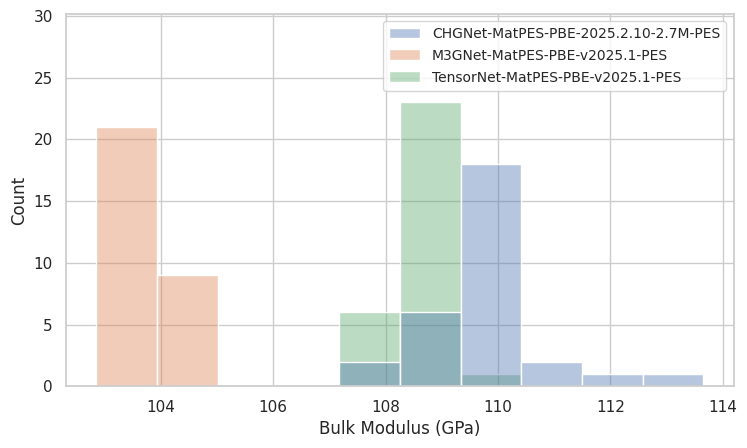

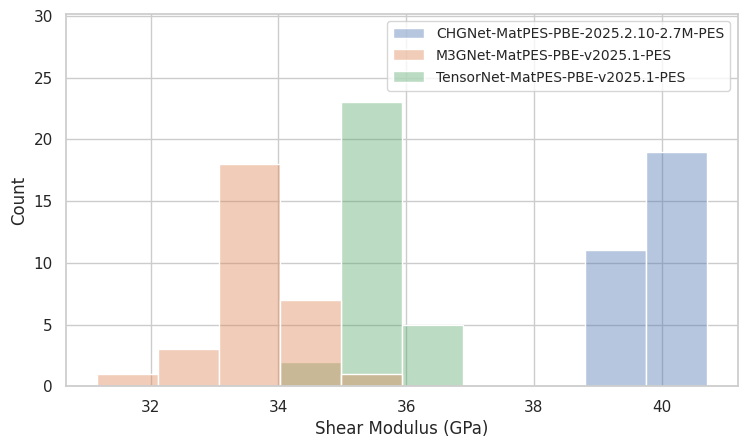

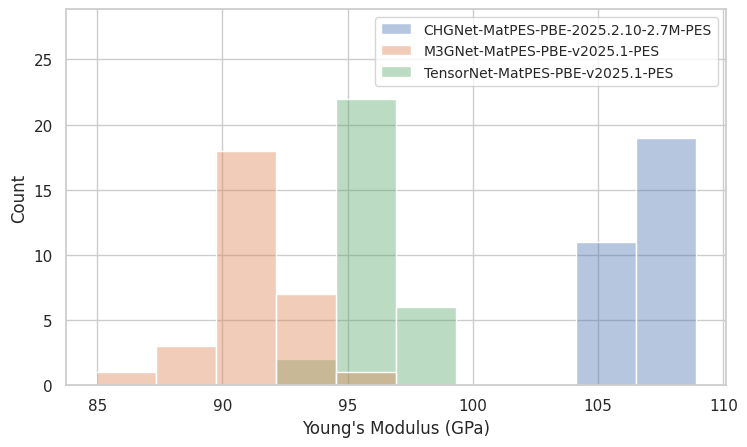

In [76]:
df_all = pd.concat(df_ls, ignore_index=True)

props = ['bulk_vrh_gpa', 'shear_vrh_gpa', 'youngs_gpa']
labels = {
    'bulk_vrh_gpa': 'Bulk Modulus (GPa)',
    'shear_vrh_gpa': 'Shear Modulus (GPa)',
    'youngs_gpa': "Young's Modulus (GPa)"
}

rc = {"font.size": 24}


sns.set_theme(style='whitegrid', rc=rc)
for prop in props:
    plt.figure(figsize=(8, 5))
    ax = sns.histplot(data=df_all, x=prop, hue='iap', element='bars', stat='count', common_norm=False, bins=10, alpha=0.4)

    leg = ax.get_legend()
    leg.set_title("")
    for text in leg.get_texts():      # all label texts
        text.set_fontsize(10)
    leg.set_loc("upper right")  # put legend inside top-right


    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.25)
    plt.xlabel(labels[prop])
    plt.tight_layout()
    plt.show()

In [41]:
props = ['bulk_vrh_gpa', 'shear_vrh_gpa', 'youngs_gpa']
df_group_stats = df_all.groupby('iap')[props].agg(['mean', 'std'])
print(df_group_stats)


                                     bulk_vrh_gpa           shear_vrh_gpa  \
                                             mean       std          mean   
iap                                                                         
CHGNet-MatPES-PBE-2025.2.10-2.7M-PES   109.868953  1.013176     39.979859   
M3GNet-MatPES-PBE-v2025.1-PES          103.727927  0.437066     33.690020   
TensorNet-MatPES-PBE-v2025.1-PES       108.592317  0.375437     35.481842   

                                                youngs_gpa            
                                           std        mean       std  
iap                                                                   
CHGNet-MatPES-PBE-2025.2.10-2.7M-PES  0.460236  106.964368  1.169536  
M3GNet-MatPES-PBE-v2025.1-PES         0.782615   91.192306  1.912159  
TensorNet-MatPES-PBE-v2025.1-PES      0.415030   95.989749  1.024498  


# Aug 26

## Trying out smaller supercell size (Ti75.25Al20Cr4.75)

num_atoms = 54, 128, 250

In [1]:
from mp_api.client import MPRester
import numpy as np

# bcc Ti, Al and Cr
mp_ids = ["mp-73", "mp-998860", "mp-90"]

MP_API_KEY = 'd3bZ5jRgDZ3uYsKhZnUK4agoNYBjj4og'

mpr =  MPRester(MP_API_KEY)

lattice_params = []
mats = mpr.materials.search(mp_ids, fields=["structure"])

for mat in mats:
    struct = mat.structure
    a = struct.lattice.a  # For cubic cells
    lattice_params.append(a)
    
print(lattice_params)
avg_params = np.mean(lattice_params)
print(f"Average lattice parameter: {avg_params}")

Retrieving MaterialsDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

[2.96889915140125, 2.8159986696554085, 2.756071617033191]
Average lattice parameter: 2.8469898126966164


In [2]:
from math import ceil
from fractions import Fraction
import numpy as np
import random
from pymatgen.core import Lattice, Structure, Composition
import datetime
import os

BASE_SEED = 42

def build_bcc_random_structs(comp_str, avg_params, num_atoms='auto', num_structs=1, base_seed=42):
    """Return list of randomized BCC supercell Structures for a composition.

    - comp_str: composition string understood by pymatgen Composition, e.g. 'Ti75.25Al20Cr4.75'
    - avg_params: lattice parameter (a) for cubic lattice
    - num_structs: number of randomized structures to produce
    - base_seed: integer seed for deterministic shuffles

    Returns: (struct_list, counts_dict, supercell_size_n)
    """
    comp = Composition(comp_str)
    fractions = {el.symbol: comp.get_atomic_fraction(el) for el in comp.elements}


    if num_atoms == 'auto':
        # find a small rational denominator set (not strictly required, but useful)
        denoms = [Fraction(str(frac)).limit_denominator().denominator for frac in fractions.values()]
        N = int(np.lcm.reduce(denoms))

        # select minimal cubic BCC supercell size n so total atoms = 2 * n^3 >= N
        n = int(ceil((N / 2) ** (1 / 3)))
        total_atoms = 2 * n ** 3
    else:
        n = int(ceil((num_atoms / 2) ** (1 / 3)))
        total_atoms = 2 * n ** 3

    # compute integer counts summing exactly to total_atoms
    counts = {el: int(np.floor(fractions[el] * total_atoms)) for el in fractions}
    assigned = sum(counts.values())
    remainder = total_atoms - assigned
    if remainder > 0:
        frac_remainders = {el: (fractions[el] * total_atoms - counts[el]) for el in fractions}
        for el in sorted(frac_remainders, key=frac_remainders.get, reverse=True)[:remainder]:
            counts[el] += 1

    # build species list
    species = []
    for el, cnt in counts.items():
        species.extend([el] * cnt)

    # primitive BCC and supercell
    prim = Structure(Lattice.cubic(avg_params), ["X", "X"], [(0, 0, 0), (0.5, 0.5, 0.5)])
    supercell = prim * (n, n, n)

    if len(supercell) != len(species):
        raise RuntimeError(f"supercell sites ({len(supercell)}) != species ({len(species)})")

    structs = []
    for i in range(num_structs):
        seed = base_seed + i
        random.seed(seed)
        shuffled = species.copy()
        random.shuffle(shuffled)
        sc = supercell.copy()
        for idx, sp in enumerate(shuffled):
            sc.replace(idx, sp)
        structs.append(sc)

    return structs, counts, n

comp_str = "Ti75.25Al20Cr4.75"
num_structs = 30


date_str = datetime.datetime.now().strftime('%Y_%m_%d')
subfolder = f"data/output/{date_str}/"
os.makedirs(subfolder, exist_ok=True)

In [3]:
import os 

num_atoms_ls = [54, 128, 250]

for num_atoms in num_atoms_ls:
    print(f"\nNumber of atoms: {num_atoms}")

    struct_ls, counts, n = build_bcc_random_structs(comp_str, avg_params,num_atoms=num_atoms, num_structs=num_structs, base_seed=BASE_SEED)
    print(f"Rebuilt {len(struct_ls)} structure(s); supercell = {n}x{n}x{n} ({len(struct_ls[0])} sites)")
    print("Atom counts:", counts)

    unique_structs = set(str(s) for s in struct_ls)
    print(f"Number of unique structures: {len(unique_structs)} out of {len(struct_ls)}")

    subsubfolder = f"data/output/{date_str}/cif_{len(struct_ls[0])}atoms"

    os.makedirs(subsubfolder, exist_ok=True)

    for index, struct in enumerate(struct_ls):
        struct.to_file(f"{subsubfolder}/random_struct_{index}.cif")
    print(f"Saved {len(struct_ls)} structures to {subsubfolder}")


Number of atoms: 54
Rebuilt 30 structure(s); supercell = 3x3x3 (54 sites)
Atom counts: {'Ti': 41, 'Al': 11, 'Cr': 2}
Number of unique structures: 30 out of 30
Saved 30 structures to data/output/2025_08_26/cif_54atoms

Number of atoms: 128
Rebuilt 30 structure(s); supercell = 4x4x4 (128 sites)
Atom counts: {'Ti': 96, 'Al': 26, 'Cr': 6}
Number of unique structures: 30 out of 30Rebuilt 30 structure(s); supercell = 3x3x3 (54 sites)
Atom counts: {'Ti': 41, 'Al': 11, 'Cr': 2}
Number of unique structures: 30 out of 30
Saved 30 structures to data/output/2025_08_26/cif_54atoms

Number of atoms: 128
Rebuilt 30 structure(s); supercell = 4x4x4 (128 sites)
Atom counts: {'Ti': 96, 'Al': 26, 'Cr': 6}
Number of unique structures: 30 out of 30
Saved 30 structures to data/output/2025_08_26/cif_128atoms

Number of atoms: 250

Saved 30 structures to data/output/2025_08_26/cif_128atoms

Number of atoms: 250
Rebuilt 30 structure(s); supercell = 5x5x5 (250 sites)
Atom counts: {'Ti': 188, 'Al': 50, 'Cr': 12}

In [4]:
# Code to double check length and composition correct

num_atoms_ls = [54, 128, 250]

for num_atoms in num_atoms_ls:
    subsubfolder = f"data/output/{date_str}/cif_{num_atoms}atoms"
    cif_files = [f for f in os.listdir(subsubfolder) if f.endswith('.cif')]

    assert len(cif_files) == num_structs, f"Expected {num_structs} CIF files, found {len(cif_files)}"

    print(f"\nChecking {len(cif_files)} files in {subsubfolder}...")

    _, counts, __ = build_bcc_random_structs(comp_str, avg_params,num_atoms=num_atoms, num_structs=1, base_seed=BASE_SEED)

    for cif_file in cif_files:
        struct = Structure.from_file(os.path.join(subsubfolder, cif_file))

        assert len(struct) == num_atoms, f"Expected {num_atoms} atoms, found {len(struct)}"

        comp = Composition(struct.composition)
        assert counts == comp.get_el_amt_dict(), f"Expected counts {counts}, found {comp.get_el_amt_dict()}"



Checking 30 files in data/output/2025_08_26/cif_54atoms...

Checking 30 files in data/output/2025_08_26/cif_128atoms...


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/pymatgen/core/structure.py:3107: UserWarning: Issues encountered while parsing CIF: 54 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]



Checking 30 files in data/output/2025_08_26/cif_250atoms...


In [ ]:
 # Calculations
import matcalc as mtc
import time
import pandas as pd
import datetime
import os

date_str = datetime.datetime.now().strftime('%Y_%m_%d')
subfolder = f"data/output/{date_str}/"
os.makedirs(subfolder, exist_ok=True)

num_atoms_ls = [54, 128, 250]

UNITS_MULTIPLIER = 160.2176621 # unit conversions for eV/A^3 to GPa

def safe_comp_str(s: str) -> str:
    import re
    s = s.replace('.', 'p')                         # 75.25 -> 75p25
    s = re.sub(r'(?<!^)(?=[A-Z])', '_', s)          # insert _ before each capital (except start)
    s = re.sub(r'[^A-Za-z0-9._-]', '_', s)          # allow limited safe chars
    s = re.sub(r'_+', '_', s).strip('_')            # collapse multiple underscores
    return s

comp_safe_str = safe_comp_str(comp_str)


# iaps = ['CHGNet-MatPES-PBE-2025.2.10-2.7M-PES', 'M3GNet-MatPES-PBE-v2025.1-PES', 'TensorNet-MatPES-PBE-v2025.1-PES']

iaps = ['M3GNet-MatPES-PBE-v2025.1-PES', 'CHGNet-MatPES-PBE-2025.2.10-2.7M-PES', 'TensorNet-MatPES-PBE-v2025.1-PES']

log_filename = os.path.join(subfolder, f"calc_times_{date_str}.log")
with open(log_filename, "a") as log_file:

    for num_atoms in num_atoms_ls:
        print(f"\nNumber of atoms: {num_atoms}")

        subsubfolder = f"data/output/{date_str}/cif_{num_atoms}atoms"
        cif_files = [f for f in os.listdir(subsubfolder) if f.endswith('.cif')]
        struct_ls = [Structure.from_file(os.path.join(subsubfolder, f)) for f in cif_files]

        for iap in iaps:
            calculator = mtc.ElasticityCalc(iap, relax_structure=True)
            start = time.time()
            elasticity_data = list(calculator.calc_many(struct_ls, n_jobs=-1))
            elapsed = time.time() - start
            log_line = f"[{iap}] calc_many for {len(struct_ls)} structures ({num_atoms} atoms): {elapsed:.2f} seconds\n"
            print(log_line.strip())
            log_file.write(log_line)
            df = pd.DataFrame(elasticity_data)
            df.to_csv(f"{subfolder}/data_{comp_safe_str}_{num_atoms}atoms_{num_structs}structs_{iap}.csv")



Number of atoms: 54


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/pymatgen/core/structure.py:3107: UserWarning: Issues encountered while parsing CIF: 54 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  struct = parser.parse_structures(primitive=primitive)[0]
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matgl/utils/io.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the u

[M3GNet-MatPES-PBE-v2025.1-PES] calc_many for 30 structures (54 atoms): 16.80 seconds


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

[CHGNet-MatPES-PBE-2025.2.10-2.7M-PES] calc_many for 30 structures (54 atoms): 89.62 seconds


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/l

[TensorNet-MatPES-PBE-v2025.1-PES] calc_many for 30 structures (54 atoms): 27.87 seconds

Number of atoms: 128


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/l

[M3GNet-MatPES-PBE-v2025.1-PES] calc_many for 30 structures (128 atoms): 207.64 seconds
[CHGNet-MatPES-PBE-2025.2.10-2.7M-PES] calc_many for 30 structures (128 atoms): 519.80 seconds
[CHGNet-MatPES-PBE-2025.2.10-2.7M-PES] calc_many for 30 structures (128 atoms): 519.80 seconds


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/l

[TensorNet-MatPES-PBE-v2025.1-PES] calc_many for 30 structures (128 atoms): 121.92 seconds

Number of atoms: 250

Number of atoms: 250


/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/lib/python3.12/site-packages/matcalc/utils.py:52: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)
/home/lengze/exit/envs/matcalc_env/l